In [1]:
# Code to predict Rayleigh wave amplitude using deep neural networks
# Uses Earthquakes from O1,O2 period 
# Nikhil Mukund (nikhil@iucaa.in, nikhil.mukund@LIGO.ORG)
# Aug 21 2017

from __future__ import division

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import preprocessing


from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD, Adagrad, Adadelta, RMSprop, Adam
from keras import losses


Using TensorFlow backend.


In [2]:
filename = '/home/mcoughlin/Seismon/Predictions/L1O1O2_CMT/earthquakes.txt' 

'''
1: earthquake gps time
2: earthquake mag
3: p gps time
4: s gps time
5: r (2 km/s)
6: r (3.5 km/s)
7: r (5 km/s)
8: predicted ground motion (m/s)
9: lower bounding time
10: upper bounding time
11: latitude
12: longitude
13: distance
14: depth (m)
15: azimuth (deg)
16: nodalPlane1_strike
17: nodalPlane1_rake
18: nodalPlane1_dip
19: momentTensor_Mrt
20: momentTensor_Mtp
21: momentTensor_Mrp
22: momentTensor_Mtt
23: momentTensor_Mrr
24: momentTensor_Mpp
25: peak ground velocity gps time
26: peak ground velocity (m/s)
27: peak ground acceleration gps time
28: peak ground acceleration (m/s^2)
29: peak ground displacement gps time
30: peak ground displacement (m)
31: Lockloss time
32: Detector Status
'''

data = pd.read_csv(filename,delimiter=' ',header=None)


Rf_Amp_thresh = 1e-6; 
index = data[25] > Rf_Amp_thresh

data = data[:][index]
data_initial = data # Only measured values

In [3]:
# Select features [Choose from the following sets]

FeatSet_index = [1,10,7,11,12,13,14,15,16,17,18,19,20,21,22,23] # [All relevant features]
#FeatSet_index = [1,7,10,11,12,13,14,15,16,17] #  this lower set paramaters makes  sense
#FeatSet_index = [1,12,13,18,19,20,21,22,23] #  Mag, Dist, Depth + Moment Tensors
#FeatSet_index = [1,12,13] #  Just Mag, Dist, Depth
#FeatSet_index = [18,19,20,21,22,23] #  this lower set has just the moment tensor parameters
#FeatSet_index = [2,3,24,26,28,30] #  these paramaters makes no sense

Target_index = [25]


# Artificially increase samples
data_temp = data
copy_num = 8
noise_level = 1e-2

for i in range(copy_num):
    data_temp = data_temp.append(data_temp)

Rfamp_orig = data_temp[Target_index];
data_orig =  data_temp   

In [4]:


x1 = data_temp[FeatSet_index][:]
x2 = np.random.randn(*data_temp[FeatSet_index][:].shape)*noise_level
data_temp[FeatSet_index] = x1 + np.multiply(x1,x2)


y1 = data_temp[Target_index][:]
y2 = np.random.randn(len(data_temp[Target_index][:]))*noise_level
y3 = np.expand_dims(y2,axis=1)
data_temp[Target_index] = y1 + np.multiply(y1,y3)

In [5]:


data = data_temp
data_unscaled = data

X_us = np.asarray(data[FeatSet_index])
Y_us = np.asarray(data[Target_index])
x_train_us, x_test_us, y_train_us, y_test_us = train_test_split(X_us, Y_us, test_size=0.2,random_state=42)
x_train_us, x_val_us, y_train_us, y_val_us = train_test_split(x_train_us, y_train_us, test_size=0.4,random_state=42)

# Normalize Data
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

# Divide data into training, validation & testing
X = np.asarray(data[FeatSet_index])
Y = np.asarray(data[Target_index])
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3,random_state=42)

In [6]:
#############################################
# Construct the neural network and train it #
#############################################

inp_layer = x_train.shape[1]
dense_layers = 9
dense_activation = 'elu'
optimizer = 'adam'
loss = 'mse'
batch_size = 100000 #10000
Nepoch = 3000
verbose = 1
Nbatch = 1000# 100

# define the network topology  -- -- -- - - -  -  -   -   -    -  
model = Sequential()
model.add(Dense(inp_layer, input_shape=(inp_layer,), activation = 'linear'))

# this layer increases trainging time but seems to not increase performance
model.add(Dense(inp_layer, activation = 'elu'))
#model.add(Dense(Nang+Nspot, activation = 'elu'))  # try one more fully connected 

g = range( dense_layers ) # add layers; decrease size of each by half 
g.reverse()     
for k in g[0:-2]:
    model.add(Dense(2**k, activation = dense_activation))
    #model.add(Dropout(0.3))

model.add(Dense(1,    activation = 'linear'))
                                
model.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), loss=loss) 

In [7]:
model.fit(x_train, y_train,
                   validation_data = (x_val,y_val),
                   batch_size      = Nbatch,
                   epochs          = Nepoch,
                   verbose         = verbose)   

Train on 22650 samples, validate on 9708 samples
Epoch 1/3000
22650/22650 [==============================] - 0s - loss: 0.0323 - val_loss: 0.0180
Epoch 2/3000
22650/22650 [==============================] - 0s - loss: 0.0134 - val_loss: 0.0124
Epoch 3/3000
22650/22650 [==============================] - 0s - loss: 0.0105 - val_loss: 0.0093
Epoch 4/3000
22650/22650 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0070
Epoch 5/3000
22650/22650 [==============================] - 0s - loss: 0.0064 - val_loss: 0.0058
Epoch 6/3000
22650/22650 [==============================] - 0s - loss: 0.0053 - val_loss: 0.0047
Epoch 7/3000
22650/22650 [==============================] - 0s - loss: 0.0042 - val_loss: 0.0037
Epoch 8/3000
22650/22650 [==============================] - 0s - loss: 0.0033 - val_loss: 0.0029
Epoch 9/3000
22650/22650 [==============================] - 0s - loss: 0.0026 - val_loss: 0.0022
Epoch 10/3000
22650/22650 [==============================] - 0s - loss: 0.0020

22650/22650 [==============================] - 0s - loss: 6.2552e-05 - val_loss: 6.5220e-05
Epoch 79/3000
22650/22650 [==============================] - 0s - loss: 5.4915e-05 - val_loss: 5.3811e-05
Epoch 80/3000
22650/22650 [==============================] - 0s - loss: 5.8293e-05 - val_loss: 6.0516e-05
Epoch 81/3000
22650/22650 [==============================] - 0s - loss: 5.6659e-05 - val_loss: 5.2602e-05
Epoch 82/3000
22650/22650 [==============================] - 0s - loss: 5.2427e-05 - val_loss: 4.7922e-05
Epoch 83/3000
22650/22650 [==============================] - 0s - loss: 5.0803e-05 - val_loss: 5.2435e-05
Epoch 84/3000
22650/22650 [==============================] - 0s - loss: 5.6456e-05 - val_loss: 5.0361e-05
Epoch 85/3000
22650/22650 [==============================] - 0s - loss: 5.0252e-05 - val_loss: 5.0326e-05
Epoch 86/3000
22650/22650 [==============================] - 0s - loss: 5.4169e-05 - val_loss: 4.9950e-05
Epoch 87/3000
22650/22650 [==============================] -

22650/22650 [==============================] - 0s - loss: 2.5512e-05 - val_loss: 2.5953e-05
Epoch 155/3000
22650/22650 [==============================] - 0s - loss: 3.6511e-05 - val_loss: 2.9984e-05
Epoch 156/3000
22650/22650 [==============================] - 0s - loss: 2.8361e-05 - val_loss: 2.1793e-05
Epoch 157/3000
22650/22650 [==============================] - 0s - loss: 2.8405e-05 - val_loss: 2.7569e-05
Epoch 158/3000
22650/22650 [==============================] - 0s - loss: 2.7575e-05 - val_loss: 2.2670e-05
Epoch 159/3000
22650/22650 [==============================] - 0s - loss: 2.6031e-05 - val_loss: 2.8713e-05
Epoch 160/3000
22650/22650 [==============================] - 0s - loss: 2.4196e-05 - val_loss: 3.3816e-05
Epoch 161/3000
22650/22650 [==============================] - 0s - loss: 3.4454e-05 - val_loss: 2.6259e-05
Epoch 162/3000
22650/22650 [==============================] - 0s - loss: 3.1358e-05 - val_loss: 2.6463e-05
Epoch 163/3000
22650/22650 [========================

22650/22650 [==============================] - 0s - loss: 2.9554e-05 - val_loss: 2.1340e-05
Epoch 231/3000
22650/22650 [==============================] - 0s - loss: 2.9758e-05 - val_loss: 2.2702e-05
Epoch 232/3000
22650/22650 [==============================] - 0s - loss: 2.4535e-05 - val_loss: 3.7273e-05
Epoch 233/3000
22650/22650 [==============================] - 0s - loss: 3.5250e-05 - val_loss: 2.7200e-05
Epoch 234/3000
22650/22650 [==============================] - 0s - loss: 2.2607e-05 - val_loss: 2.1803e-05
Epoch 235/3000
22650/22650 [==============================] - 0s - loss: 1.8885e-05 - val_loss: 2.0456e-05
Epoch 236/3000
22650/22650 [==============================] - 0s - loss: 1.9745e-05 - val_loss: 1.8588e-05
Epoch 237/3000
22650/22650 [==============================] - 0s - loss: 1.8187e-05 - val_loss: 1.8982e-05
Epoch 238/3000
22650/22650 [==============================] - 0s - loss: 2.8509e-05 - val_loss: 2.5432e-05
Epoch 239/3000
22650/22650 [========================

22650/22650 [==============================] - 0s - loss: 1.8028e-05 - val_loss: 2.1807e-05
Epoch 307/3000
22650/22650 [==============================] - 0s - loss: 2.3915e-05 - val_loss: 2.6797e-05
Epoch 308/3000
22650/22650 [==============================] - 0s - loss: 1.8853e-05 - val_loss: 1.5927e-05
Epoch 309/3000
22650/22650 [==============================] - 0s - loss: 1.8812e-05 - val_loss: 2.3559e-05
Epoch 310/3000
22650/22650 [==============================] - 0s - loss: 2.1492e-05 - val_loss: 2.2980e-05
Epoch 311/3000
22650/22650 [==============================] - 0s - loss: 2.3894e-05 - val_loss: 1.8187e-05
Epoch 312/3000
22650/22650 [==============================] - 0s - loss: 1.6886e-05 - val_loss: 1.4395e-05
Epoch 313/3000
22650/22650 [==============================] - 0s - loss: 1.6878e-05 - val_loss: 1.5084e-05
Epoch 314/3000
22650/22650 [==============================] - 0s - loss: 2.5528e-05 - val_loss: 2.9063e-05
Epoch 315/3000
22650/22650 [========================

22650/22650 [==============================] - 0s - loss: 1.4613e-05 - val_loss: 1.8400e-05
Epoch 383/3000
22650/22650 [==============================] - 0s - loss: 1.5565e-05 - val_loss: 2.0857e-05
Epoch 384/3000
22650/22650 [==============================] - 0s - loss: 1.8050e-05 - val_loss: 2.6056e-05
Epoch 385/3000
22650/22650 [==============================] - 0s - loss: 2.5194e-05 - val_loss: 1.3075e-05
Epoch 386/3000
22650/22650 [==============================] - 0s - loss: 1.5572e-05 - val_loss: 1.1831e-05
Epoch 387/3000
22650/22650 [==============================] - 0s - loss: 1.3522e-05 - val_loss: 1.3589e-05
Epoch 388/3000
22650/22650 [==============================] - 0s - loss: 1.4138e-05 - val_loss: 1.3165e-05
Epoch 389/3000
22650/22650 [==============================] - 0s - loss: 1.3163e-05 - val_loss: 1.6484e-05
Epoch 390/3000
22650/22650 [==============================] - 0s - loss: 1.6003e-05 - val_loss: 1.2520e-05
Epoch 391/3000
22650/22650 [========================

22650/22650 [==============================] - 0s - loss: 1.3594e-05 - val_loss: 1.5511e-05
Epoch 459/3000
22650/22650 [==============================] - 0s - loss: 1.6773e-05 - val_loss: 1.3534e-05
Epoch 460/3000
22650/22650 [==============================] - 0s - loss: 1.4095e-05 - val_loss: 1.4555e-05
Epoch 461/3000
22650/22650 [==============================] - 0s - loss: 1.6105e-05 - val_loss: 1.2024e-05
Epoch 462/3000
22650/22650 [==============================] - 0s - loss: 1.5236e-05 - val_loss: 1.4002e-05
Epoch 463/3000
22650/22650 [==============================] - 0s - loss: 1.3991e-05 - val_loss: 1.1910e-05
Epoch 464/3000
22650/22650 [==============================] - 0s - loss: 1.1687e-05 - val_loss: 1.3492e-05
Epoch 465/3000
22650/22650 [==============================] - 0s - loss: 1.2547e-05 - val_loss: 1.4745e-05
Epoch 466/3000
22650/22650 [==============================] - 0s - loss: 1.1892e-05 - val_loss: 9.4943e-06
Epoch 467/3000
22650/22650 [========================

22650/22650 [==============================] - 0s - loss: 1.5213e-05 - val_loss: 1.5373e-05
Epoch 535/3000
22650/22650 [==============================] - 0s - loss: 1.4381e-05 - val_loss: 1.5389e-05
Epoch 536/3000
22650/22650 [==============================] - 0s - loss: 1.1921e-05 - val_loss: 9.8797e-06
Epoch 537/3000
22650/22650 [==============================] - 0s - loss: 9.4939e-06 - val_loss: 8.0945e-06
Epoch 538/3000
22650/22650 [==============================] - 0s - loss: 8.5992e-06 - val_loss: 8.0544e-06
Epoch 539/3000
22650/22650 [==============================] - 0s - loss: 8.7719e-06 - val_loss: 1.1709e-05
Epoch 540/3000
22650/22650 [==============================] - 0s - loss: 9.8031e-06 - val_loss: 8.8588e-06
Epoch 541/3000
22650/22650 [==============================] - 0s - loss: 1.0355e-05 - val_loss: 9.9105e-06
Epoch 542/3000
22650/22650 [==============================] - 0s - loss: 9.9324e-06 - val_loss: 1.0625e-05
Epoch 543/3000
22650/22650 [========================

22650/22650 [==============================] - 0s - loss: 8.6968e-06 - val_loss: 8.1107e-06
Epoch 611/3000
22650/22650 [==============================] - 0s - loss: 9.0620e-06 - val_loss: 1.0163e-05
Epoch 612/3000
22650/22650 [==============================] - 0s - loss: 1.1449e-05 - val_loss: 1.6788e-05
Epoch 613/3000
22650/22650 [==============================] - 0s - loss: 1.1547e-05 - val_loss: 1.0090e-05
Epoch 614/3000
22650/22650 [==============================] - 0s - loss: 8.8831e-06 - val_loss: 7.9082e-06
Epoch 615/3000
22650/22650 [==============================] - 0s - loss: 7.6397e-06 - val_loss: 1.0026e-05
Epoch 616/3000
22650/22650 [==============================] - 0s - loss: 9.5087e-06 - val_loss: 9.0542e-06
Epoch 617/3000
22650/22650 [==============================] - 0s - loss: 7.2477e-06 - val_loss: 7.0967e-06
Epoch 618/3000
22650/22650 [==============================] - 0s - loss: 8.0686e-06 - val_loss: 1.1685e-05
Epoch 619/3000
22650/22650 [========================

22650/22650 [==============================] - 0s - loss: 7.1761e-06 - val_loss: 6.3397e-06
Epoch 687/3000
22650/22650 [==============================] - 0s - loss: 6.1773e-06 - val_loss: 5.7215e-06
Epoch 688/3000
22650/22650 [==============================] - 0s - loss: 5.6928e-06 - val_loss: 5.4593e-06
Epoch 689/3000
22650/22650 [==============================] - 0s - loss: 5.9322e-06 - val_loss: 5.9010e-06
Epoch 690/3000
22650/22650 [==============================] - 0s - loss: 6.2831e-06 - val_loss: 7.0593e-06
Epoch 691/3000
22650/22650 [==============================] - 0s - loss: 7.2169e-06 - val_loss: 1.1666e-05
Epoch 692/3000
22650/22650 [==============================] - 0s - loss: 7.9704e-06 - val_loss: 1.1638e-05
Epoch 693/3000
22650/22650 [==============================] - 0s - loss: 1.0578e-05 - val_loss: 1.0446e-05
Epoch 694/3000
22650/22650 [==============================] - 0s - loss: 8.6427e-06 - val_loss: 7.7672e-06
Epoch 695/3000
22650/22650 [========================

22650/22650 [==============================] - 0s - loss: 6.7478e-06 - val_loss: 5.7690e-06
Epoch 763/3000
22650/22650 [==============================] - 0s - loss: 5.6275e-06 - val_loss: 7.6339e-06
Epoch 764/3000
22650/22650 [==============================] - 0s - loss: 6.3654e-06 - val_loss: 4.4362e-06
Epoch 765/3000
22650/22650 [==============================] - 0s - loss: 5.3420e-06 - val_loss: 7.2197e-06
Epoch 766/3000
22650/22650 [==============================] - 0s - loss: 6.3349e-06 - val_loss: 6.8671e-06
Epoch 767/3000
22650/22650 [==============================] - 0s - loss: 7.8431e-06 - val_loss: 9.1815e-06
Epoch 768/3000
22650/22650 [==============================] - 0s - loss: 8.1031e-06 - val_loss: 8.6377e-06
Epoch 769/3000
22650/22650 [==============================] - 0s - loss: 7.4073e-06 - val_loss: 4.4999e-06
Epoch 770/3000
22650/22650 [==============================] - 0s - loss: 5.6685e-06 - val_loss: 4.6270e-06
Epoch 771/3000
22650/22650 [========================

22650/22650 [==============================] - 0s - loss: 6.3569e-06 - val_loss: 6.6619e-06
Epoch 839/3000
22650/22650 [==============================] - 0s - loss: 6.7690e-06 - val_loss: 4.2344e-06
Epoch 840/3000
22650/22650 [==============================] - 0s - loss: 5.3471e-06 - val_loss: 4.9328e-06
Epoch 841/3000
22650/22650 [==============================] - 0s - loss: 5.0154e-06 - val_loss: 5.3987e-06
Epoch 842/3000
22650/22650 [==============================] - 0s - loss: 5.0751e-06 - val_loss: 3.7577e-06
Epoch 843/3000
22650/22650 [==============================] - 0s - loss: 4.3579e-06 - val_loss: 3.4164e-06
Epoch 844/3000
22650/22650 [==============================] - 0s - loss: 3.8379e-06 - val_loss: 4.8738e-06
Epoch 845/3000
22650/22650 [==============================] - 0s - loss: 7.2501e-06 - val_loss: 4.6863e-06
Epoch 846/3000
22650/22650 [==============================] - 0s - loss: 7.0425e-06 - val_loss: 8.7254e-06
Epoch 847/3000
22650/22650 [========================

22650/22650 [==============================] - 0s - loss: 3.9225e-06 - val_loss: 3.6906e-06
Epoch 915/3000
22650/22650 [==============================] - 0s - loss: 6.1383e-06 - val_loss: 4.7741e-06
Epoch 916/3000
22650/22650 [==============================] - 0s - loss: 4.7002e-06 - val_loss: 4.3853e-06
Epoch 917/3000
22650/22650 [==============================] - 0s - loss: 4.6687e-06 - val_loss: 4.6238e-06
Epoch 918/3000
22650/22650 [==============================] - 0s - loss: 5.8683e-06 - val_loss: 4.7007e-06
Epoch 919/3000
22650/22650 [==============================] - 0s - loss: 5.0140e-06 - val_loss: 4.8307e-06
Epoch 920/3000
22650/22650 [==============================] - 0s - loss: 5.2689e-06 - val_loss: 4.4844e-06
Epoch 921/3000
22650/22650 [==============================] - 0s - loss: 5.2471e-06 - val_loss: 9.2225e-06
Epoch 922/3000
22650/22650 [==============================] - 0s - loss: 1.2066e-05 - val_loss: 6.1451e-06
Epoch 923/3000
22650/22650 [========================

22650/22650 [==============================] - 0s - loss: 4.6375e-06 - val_loss: 5.0467e-06
Epoch 991/3000
22650/22650 [==============================] - 0s - loss: 4.9870e-06 - val_loss: 4.2829e-06
Epoch 992/3000
22650/22650 [==============================] - 0s - loss: 4.1176e-06 - val_loss: 4.2208e-06
Epoch 993/3000
22650/22650 [==============================] - 0s - loss: 4.1609e-06 - val_loss: 3.4143e-06
Epoch 994/3000
22650/22650 [==============================] - 0s - loss: 3.7732e-06 - val_loss: 4.4247e-06
Epoch 995/3000
22650/22650 [==============================] - 0s - loss: 4.1256e-06 - val_loss: 7.3026e-06
Epoch 996/3000
22650/22650 [==============================] - 0s - loss: 5.4037e-06 - val_loss: 7.0171e-06
Epoch 997/3000
22650/22650 [==============================] - 0s - loss: 4.9847e-06 - val_loss: 4.9106e-06
Epoch 998/3000
22650/22650 [==============================] - 0s - loss: 5.2256e-06 - val_loss: 5.7085e-06
Epoch 999/3000
22650/22650 [========================

22650/22650 [==============================] - 0s - loss: 4.2615e-06 - val_loss: 4.7149e-06
Epoch 1067/3000
22650/22650 [==============================] - 0s - loss: 5.3826e-06 - val_loss: 4.9178e-06
Epoch 1068/3000
22650/22650 [==============================] - 0s - loss: 7.0890e-06 - val_loss: 7.3622e-06
Epoch 1069/3000
22650/22650 [==============================] - 0s - loss: 6.7193e-06 - val_loss: 7.2427e-06
Epoch 1070/3000
22650/22650 [==============================] - 0s - loss: 6.4126e-06 - val_loss: 7.0402e-06
Epoch 1071/3000
22650/22650 [==============================] - 0s - loss: 7.4145e-06 - val_loss: 4.5877e-06
Epoch 1072/3000
22650/22650 [==============================] - 0s - loss: 5.0170e-06 - val_loss: 5.2437e-06
Epoch 1073/3000
22650/22650 [==============================] - 0s - loss: 4.2676e-06 - val_loss: 4.2980e-06
Epoch 1074/3000
22650/22650 [==============================] - 0s - loss: 3.9389e-06 - val_loss: 3.8809e-06
Epoch 1075/3000
22650/22650 [===============

22650/22650 [==============================] - 0s - loss: 3.3006e-06 - val_loss: 3.5224e-06
Epoch 1143/3000
22650/22650 [==============================] - 0s - loss: 3.9209e-06 - val_loss: 3.9172e-06
Epoch 1144/3000
22650/22650 [==============================] - 0s - loss: 3.9721e-06 - val_loss: 3.3611e-06
Epoch 1145/3000
22650/22650 [==============================] - 0s - loss: 3.4872e-06 - val_loss: 3.3742e-06
Epoch 1146/3000
22650/22650 [==============================] - 0s - loss: 3.3137e-06 - val_loss: 4.3802e-06
Epoch 1147/3000
22650/22650 [==============================] - 0s - loss: 4.1852e-06 - val_loss: 3.6068e-06
Epoch 1148/3000
22650/22650 [==============================] - 0s - loss: 3.8507e-06 - val_loss: 3.5106e-06
Epoch 1149/3000
22650/22650 [==============================] - 0s - loss: 3.9286e-06 - val_loss: 3.5164e-06
Epoch 1150/3000
22650/22650 [==============================] - 0s - loss: 4.5903e-06 - val_loss: 5.5929e-06
Epoch 1151/3000
22650/22650 [===============

22650/22650 [==============================] - 0s - loss: 3.1105e-06 - val_loss: 3.1794e-06
Epoch 1219/3000
22650/22650 [==============================] - 0s - loss: 3.7800e-06 - val_loss: 6.3673e-06
Epoch 1220/3000
22650/22650 [==============================] - 0s - loss: 4.7741e-06 - val_loss: 3.1187e-06
Epoch 1221/3000
22650/22650 [==============================] - 0s - loss: 3.5330e-06 - val_loss: 3.5839e-06
Epoch 1222/3000
22650/22650 [==============================] - 0s - loss: 4.4039e-06 - val_loss: 3.1176e-06
Epoch 1223/3000
22650/22650 [==============================] - 0s - loss: 4.0546e-06 - val_loss: 3.2633e-06
Epoch 1224/3000
22650/22650 [==============================] - 0s - loss: 2.9295e-06 - val_loss: 3.2044e-06
Epoch 1225/3000
22650/22650 [==============================] - 0s - loss: 3.5823e-06 - val_loss: 3.0026e-06
Epoch 1226/3000
22650/22650 [==============================] - 0s - loss: 3.4112e-06 - val_loss: 4.5266e-06
Epoch 1227/3000
22650/22650 [===============

22650/22650 [==============================] - 0s - loss: 4.1147e-06 - val_loss: 6.3092e-06
Epoch 1295/3000
22650/22650 [==============================] - 0s - loss: 3.8054e-06 - val_loss: 3.0578e-06
Epoch 1296/3000
22650/22650 [==============================] - 0s - loss: 3.1078e-06 - val_loss: 3.7090e-06
Epoch 1297/3000
22650/22650 [==============================] - 0s - loss: 3.9623e-06 - val_loss: 5.4588e-06
Epoch 1298/3000
22650/22650 [==============================] - 0s - loss: 4.1474e-06 - val_loss: 5.0147e-06
Epoch 1299/3000
22650/22650 [==============================] - 0s - loss: 4.2473e-06 - val_loss: 2.7165e-06
Epoch 1300/3000
22650/22650 [==============================] - 0s - loss: 4.0770e-06 - val_loss: 3.4921e-06
Epoch 1301/3000
22650/22650 [==============================] - 0s - loss: 3.4966e-06 - val_loss: 3.5064e-06
Epoch 1302/3000
22650/22650 [==============================] - 0s - loss: 3.8078e-06 - val_loss: 2.4864e-06
Epoch 1303/3000
22650/22650 [===============

22650/22650 [==============================] - 0s - loss: 3.0709e-06 - val_loss: 2.6193e-06
Epoch 1371/3000
22650/22650 [==============================] - 0s - loss: 3.0403e-06 - val_loss: 2.9378e-06
Epoch 1372/3000
22650/22650 [==============================] - 0s - loss: 3.2592e-06 - val_loss: 2.5838e-06
Epoch 1373/3000
22650/22650 [==============================] - 0s - loss: 3.0023e-06 - val_loss: 2.5640e-06
Epoch 1374/3000
22650/22650 [==============================] - 0s - loss: 3.0926e-06 - val_loss: 2.6460e-06
Epoch 1375/3000
22650/22650 [==============================] - 0s - loss: 2.7196e-06 - val_loss: 4.6803e-06
Epoch 1376/3000
22650/22650 [==============================] - 0s - loss: 3.5198e-06 - val_loss: 3.6665e-06
Epoch 1377/3000
22650/22650 [==============================] - 0s - loss: 2.8187e-06 - val_loss: 2.4324e-06
Epoch 1378/3000
22650/22650 [==============================] - 0s - loss: 2.6693e-06 - val_loss: 3.4102e-06
Epoch 1379/3000
22650/22650 [===============

22650/22650 [==============================] - 0s - loss: 3.2118e-06 - val_loss: 2.8528e-06
Epoch 1447/3000
22650/22650 [==============================] - 0s - loss: 3.1643e-06 - val_loss: 4.1846e-06
Epoch 1448/3000
22650/22650 [==============================] - 0s - loss: 4.2056e-06 - val_loss: 2.6880e-06
Epoch 1449/3000
22650/22650 [==============================] - 0s - loss: 2.7971e-06 - val_loss: 3.4016e-06
Epoch 1450/3000
22650/22650 [==============================] - 0s - loss: 2.9335e-06 - val_loss: 2.4838e-06
Epoch 1451/3000
22650/22650 [==============================] - 0s - loss: 2.7563e-06 - val_loss: 2.8200e-06
Epoch 1452/3000
22650/22650 [==============================] - 0s - loss: 3.3034e-06 - val_loss: 2.6115e-06
Epoch 1453/3000
22650/22650 [==============================] - 0s - loss: 4.0285e-06 - val_loss: 3.2308e-06
Epoch 1454/3000
22650/22650 [==============================] - 0s - loss: 3.3401e-06 - val_loss: 3.6925e-06
Epoch 1455/3000
22650/22650 [===============

22650/22650 [==============================] - 0s - loss: 2.9279e-06 - val_loss: 2.7610e-06
Epoch 1523/3000
22650/22650 [==============================] - 0s - loss: 2.5952e-06 - val_loss: 2.7748e-06
Epoch 1524/3000
22650/22650 [==============================] - 0s - loss: 2.7460e-06 - val_loss: 2.3161e-06
Epoch 1525/3000
22650/22650 [==============================] - 0s - loss: 2.9989e-06 - val_loss: 3.2565e-06
Epoch 1526/3000
22650/22650 [==============================] - 0s - loss: 3.1875e-06 - val_loss: 2.4772e-06
Epoch 1527/3000
22650/22650 [==============================] - 0s - loss: 3.2934e-06 - val_loss: 3.4542e-06
Epoch 1528/3000
22650/22650 [==============================] - 0s - loss: 3.0133e-06 - val_loss: 2.8317e-06
Epoch 1529/3000
22650/22650 [==============================] - 0s - loss: 3.2931e-06 - val_loss: 2.8591e-06
Epoch 1530/3000
22650/22650 [==============================] - 0s - loss: 3.2418e-06 - val_loss: 4.1888e-06
Epoch 1531/3000
22650/22650 [===============

22650/22650 [==============================] - 0s - loss: 2.6471e-06 - val_loss: 3.1593e-06
Epoch 1599/3000
22650/22650 [==============================] - 0s - loss: 3.5528e-06 - val_loss: 4.3206e-06
Epoch 1600/3000
22650/22650 [==============================] - 0s - loss: 3.3946e-06 - val_loss: 2.7063e-06
Epoch 1601/3000
22650/22650 [==============================] - 0s - loss: 3.7639e-06 - val_loss: 3.7584e-06
Epoch 1602/3000
22650/22650 [==============================] - 0s - loss: 2.9230e-06 - val_loss: 2.5577e-06
Epoch 1603/3000
22650/22650 [==============================] - 0s - loss: 2.5436e-06 - val_loss: 2.7156e-06
Epoch 1604/3000
22650/22650 [==============================] - 0s - loss: 2.8416e-06 - val_loss: 3.4811e-06
Epoch 1605/3000
22650/22650 [==============================] - 0s - loss: 3.0415e-06 - val_loss: 3.8617e-06
Epoch 1606/3000
22650/22650 [==============================] - 0s - loss: 2.8614e-06 - val_loss: 2.5960e-06
Epoch 1607/3000
22650/22650 [===============

22650/22650 [==============================] - 0s - loss: 2.6199e-06 - val_loss: 2.7987e-06
Epoch 1675/3000
22650/22650 [==============================] - 0s - loss: 2.6007e-06 - val_loss: 2.4209e-06
Epoch 1676/3000
22650/22650 [==============================] - 0s - loss: 2.4555e-06 - val_loss: 2.7089e-06
Epoch 1677/3000
22650/22650 [==============================] - 0s - loss: 2.8216e-06 - val_loss: 2.4129e-06
Epoch 1678/3000
22650/22650 [==============================] - 0s - loss: 2.8078e-06 - val_loss: 2.8610e-06
Epoch 1679/3000
22650/22650 [==============================] - 0s - loss: 3.1213e-06 - val_loss: 3.2036e-06
Epoch 1680/3000
22650/22650 [==============================] - 0s - loss: 3.6876e-06 - val_loss: 4.1019e-06
Epoch 1681/3000
22650/22650 [==============================] - 0s - loss: 4.2617e-06 - val_loss: 2.6867e-06
Epoch 1682/3000
22650/22650 [==============================] - 0s - loss: 2.9339e-06 - val_loss: 2.4424e-06
Epoch 1683/3000
22650/22650 [===============

22650/22650 [==============================] - 0s - loss: 2.7284e-06 - val_loss: 2.5697e-06
Epoch 1751/3000
22650/22650 [==============================] - 0s - loss: 2.4557e-06 - val_loss: 2.2956e-06
Epoch 1752/3000
22650/22650 [==============================] - 0s - loss: 2.3981e-06 - val_loss: 2.8498e-06
Epoch 1753/3000
22650/22650 [==============================] - 0s - loss: 2.8952e-06 - val_loss: 3.8707e-06
Epoch 1754/3000
22650/22650 [==============================] - 0s - loss: 3.2158e-06 - val_loss: 3.0080e-06
Epoch 1755/3000
22650/22650 [==============================] - 0s - loss: 3.1612e-06 - val_loss: 3.4673e-06
Epoch 1756/3000
22650/22650 [==============================] - 0s - loss: 3.3786e-06 - val_loss: 2.8619e-06
Epoch 1757/3000
22650/22650 [==============================] - 0s - loss: 3.3495e-06 - val_loss: 3.5082e-06
Epoch 1758/3000
22650/22650 [==============================] - 0s - loss: 2.9267e-06 - val_loss: 2.3097e-06
Epoch 1759/3000
22650/22650 [===============

22650/22650 [==============================] - 0s - loss: 2.8987e-06 - val_loss: 2.2410e-06
Epoch 1827/3000
22650/22650 [==============================] - 0s - loss: 2.3553e-06 - val_loss: 2.4269e-06
Epoch 1828/3000
22650/22650 [==============================] - 0s - loss: 2.3404e-06 - val_loss: 2.2028e-06
Epoch 1829/3000
22650/22650 [==============================] - 0s - loss: 2.2656e-06 - val_loss: 2.4585e-06
Epoch 1830/3000
22650/22650 [==============================] - 0s - loss: 2.6461e-06 - val_loss: 2.2915e-06
Epoch 1831/3000
22650/22650 [==============================] - 0s - loss: 2.5115e-06 - val_loss: 2.5979e-06
Epoch 1832/3000
22650/22650 [==============================] - 0s - loss: 2.9534e-06 - val_loss: 3.3753e-06
Epoch 1833/3000
22650/22650 [==============================] - 0s - loss: 2.8951e-06 - val_loss: 3.4988e-06
Epoch 1834/3000
22650/22650 [==============================] - 0s - loss: 3.3985e-06 - val_loss: 2.7283e-06
Epoch 1835/3000
22650/22650 [===============

22650/22650 [==============================] - 0s - loss: 3.0329e-06 - val_loss: 4.2618e-06
Epoch 1903/3000
22650/22650 [==============================] - 0s - loss: 3.4516e-06 - val_loss: 4.3382e-06
Epoch 1904/3000
22650/22650 [==============================] - 0s - loss: 3.1368e-06 - val_loss: 2.3580e-06
Epoch 1905/3000
22650/22650 [==============================] - 0s - loss: 2.4973e-06 - val_loss: 2.3955e-06
Epoch 1906/3000
22650/22650 [==============================] - 0s - loss: 2.6683e-06 - val_loss: 2.2949e-06
Epoch 1907/3000
22650/22650 [==============================] - 0s - loss: 2.8746e-06 - val_loss: 2.6712e-06
Epoch 1908/3000
22650/22650 [==============================] - 0s - loss: 2.9853e-06 - val_loss: 2.3532e-06
Epoch 1909/3000
22650/22650 [==============================] - 0s - loss: 2.4193e-06 - val_loss: 2.8119e-06
Epoch 1910/3000
22650/22650 [==============================] - 0s - loss: 4.1800e-06 - val_loss: 4.4076e-06
Epoch 1911/3000
22650/22650 [===============

22650/22650 [==============================] - 0s - loss: 2.9049e-06 - val_loss: 2.4497e-06
Epoch 1979/3000
22650/22650 [==============================] - 0s - loss: 2.6013e-06 - val_loss: 2.4439e-06
Epoch 1980/3000
22650/22650 [==============================] - 0s - loss: 2.6957e-06 - val_loss: 2.4273e-06
Epoch 1981/3000
22650/22650 [==============================] - 0s - loss: 2.7426e-06 - val_loss: 2.4338e-06
Epoch 1982/3000
22650/22650 [==============================] - 0s - loss: 2.4996e-06 - val_loss: 2.5611e-06
Epoch 1983/3000
22650/22650 [==============================] - 0s - loss: 3.0658e-06 - val_loss: 4.2784e-06
Epoch 1984/3000
22650/22650 [==============================] - 0s - loss: 3.6057e-06 - val_loss: 2.4112e-06
Epoch 1985/3000
22650/22650 [==============================] - 0s - loss: 2.5639e-06 - val_loss: 2.6231e-06
Epoch 1986/3000
22650/22650 [==============================] - 0s - loss: 2.7406e-06 - val_loss: 3.1185e-06
Epoch 1987/3000
22650/22650 [===============

22650/22650 [==============================] - 0s - loss: 3.6076e-06 - val_loss: 2.7512e-06
Epoch 2055/3000
22650/22650 [==============================] - 0s - loss: 2.9576e-06 - val_loss: 2.8510e-06
Epoch 2056/3000
22650/22650 [==============================] - 0s - loss: 2.6840e-06 - val_loss: 2.8246e-06
Epoch 2057/3000
22650/22650 [==============================] - 0s - loss: 2.6434e-06 - val_loss: 2.1365e-06
Epoch 2058/3000
22650/22650 [==============================] - 0s - loss: 2.2978e-06 - val_loss: 2.7023e-06
Epoch 2059/3000
22650/22650 [==============================] - 0s - loss: 2.6817e-06 - val_loss: 2.7899e-06
Epoch 2060/3000
22650/22650 [==============================] - 0s - loss: 2.9234e-06 - val_loss: 2.7178e-06
Epoch 2061/3000
22650/22650 [==============================] - 0s - loss: 2.6509e-06 - val_loss: 2.2422e-06
Epoch 2062/3000
22650/22650 [==============================] - 0s - loss: 2.4127e-06 - val_loss: 2.4298e-06
Epoch 2063/3000
22650/22650 [===============

22650/22650 [==============================] - 0s - loss: 2.4692e-06 - val_loss: 2.4433e-06
Epoch 2131/3000
22650/22650 [==============================] - 0s - loss: 2.6483e-06 - val_loss: 2.2923e-06
Epoch 2132/3000
22650/22650 [==============================] - 0s - loss: 2.2905e-06 - val_loss: 2.2772e-06
Epoch 2133/3000
22650/22650 [==============================] - 0s - loss: 2.6025e-06 - val_loss: 2.6594e-06
Epoch 2134/3000
22650/22650 [==============================] - 0s - loss: 2.8106e-06 - val_loss: 2.3245e-06
Epoch 2135/3000
22650/22650 [==============================] - 0s - loss: 2.5311e-06 - val_loss: 2.8641e-06
Epoch 2136/3000
22650/22650 [==============================] - 0s - loss: 3.0453e-06 - val_loss: 3.1739e-06
Epoch 2137/3000
22650/22650 [==============================] - 0s - loss: 2.8194e-06 - val_loss: 2.1901e-06
Epoch 2138/3000
22650/22650 [==============================] - 0s - loss: 2.9097e-06 - val_loss: 3.0726e-06
Epoch 2139/3000
22650/22650 [===============

22650/22650 [==============================] - 0s - loss: 2.2674e-06 - val_loss: 2.4743e-06
Epoch 2207/3000
22650/22650 [==============================] - 0s - loss: 2.5773e-06 - val_loss: 2.2819e-06
Epoch 2208/3000
22650/22650 [==============================] - 0s - loss: 2.4608e-06 - val_loss: 4.4377e-06
Epoch 2209/3000
22650/22650 [==============================] - 0s - loss: 3.0706e-06 - val_loss: 2.5921e-06
Epoch 2210/3000
22650/22650 [==============================] - 0s - loss: 2.4316e-06 - val_loss: 2.1898e-06
Epoch 2211/3000
22650/22650 [==============================] - 0s - loss: 2.6998e-06 - val_loss: 2.4358e-06
Epoch 2212/3000
22650/22650 [==============================] - 0s - loss: 2.4919e-06 - val_loss: 2.4676e-06
Epoch 2213/3000
22650/22650 [==============================] - 0s - loss: 2.7215e-06 - val_loss: 2.9595e-06
Epoch 2214/3000
22650/22650 [==============================] - 0s - loss: 2.2976e-06 - val_loss: 2.0979e-06
Epoch 2215/3000
22650/22650 [===============

22650/22650 [==============================] - 0s - loss: 2.6266e-06 - val_loss: 2.7040e-06
Epoch 2283/3000
22650/22650 [==============================] - 0s - loss: 3.0245e-06 - val_loss: 2.9485e-06
Epoch 2284/3000
22650/22650 [==============================] - 0s - loss: 2.8373e-06 - val_loss: 2.0449e-06
Epoch 2285/3000
22650/22650 [==============================] - 0s - loss: 2.9327e-06 - val_loss: 2.2830e-06
Epoch 2286/3000
22650/22650 [==============================] - 0s - loss: 2.3184e-06 - val_loss: 2.4432e-06
Epoch 2287/3000
22650/22650 [==============================] - 0s - loss: 2.1441e-06 - val_loss: 3.5648e-06
Epoch 2288/3000
22650/22650 [==============================] - 0s - loss: 2.7936e-06 - val_loss: 3.6241e-06
Epoch 2289/3000
22650/22650 [==============================] - 0s - loss: 2.5742e-06 - val_loss: 2.6607e-06
Epoch 2290/3000
22650/22650 [==============================] - 0s - loss: 2.4349e-06 - val_loss: 2.3235e-06
Epoch 2291/3000
22650/22650 [===============

22650/22650 [==============================] - 0s - loss: 2.2961e-06 - val_loss: 2.5044e-06
Epoch 2359/3000
22650/22650 [==============================] - 0s - loss: 2.7188e-06 - val_loss: 3.4146e-06
Epoch 2360/3000
22650/22650 [==============================] - 0s - loss: 2.8450e-06 - val_loss: 2.4497e-06
Epoch 2361/3000
22650/22650 [==============================] - 0s - loss: 2.4047e-06 - val_loss: 1.9509e-06
Epoch 2362/3000
22650/22650 [==============================] - 0s - loss: 2.2636e-06 - val_loss: 3.5750e-06
Epoch 2363/3000
22650/22650 [==============================] - 0s - loss: 3.0795e-06 - val_loss: 4.2566e-06
Epoch 2364/3000
22650/22650 [==============================] - 0s - loss: 3.1298e-06 - val_loss: 2.7937e-06
Epoch 2365/3000
22650/22650 [==============================] - 0s - loss: 2.7623e-06 - val_loss: 2.6730e-06
Epoch 2366/3000
22650/22650 [==============================] - 0s - loss: 2.4392e-06 - val_loss: 2.6805e-06
Epoch 2367/3000
22650/22650 [===============

22650/22650 [==============================] - 0s - loss: 2.5027e-06 - val_loss: 3.2518e-06
Epoch 2435/3000
22650/22650 [==============================] - 0s - loss: 2.7821e-06 - val_loss: 2.4048e-06
Epoch 2436/3000
22650/22650 [==============================] - 0s - loss: 3.5815e-06 - val_loss: 2.5618e-06
Epoch 2437/3000
22650/22650 [==============================] - 0s - loss: 2.8387e-06 - val_loss: 4.1088e-06
Epoch 2438/3000
22650/22650 [==============================] - 0s - loss: 2.9264e-06 - val_loss: 3.1841e-06
Epoch 2439/3000
22650/22650 [==============================] - 0s - loss: 2.4028e-06 - val_loss: 2.0866e-06
Epoch 2440/3000
22650/22650 [==============================] - 0s - loss: 2.4250e-06 - val_loss: 2.5556e-06
Epoch 2441/3000
22650/22650 [==============================] - 0s - loss: 2.4262e-06 - val_loss: 2.2833e-06
Epoch 2442/3000
22650/22650 [==============================] - 0s - loss: 2.9434e-06 - val_loss: 2.5778e-06
Epoch 2443/3000
22650/22650 [===============

22650/22650 [==============================] - 0s - loss: 2.3331e-06 - val_loss: 1.9891e-06
Epoch 2511/3000
22650/22650 [==============================] - 0s - loss: 2.1781e-06 - val_loss: 2.1121e-06
Epoch 2512/3000
22650/22650 [==============================] - 0s - loss: 2.5559e-06 - val_loss: 2.4744e-06
Epoch 2513/3000
22650/22650 [==============================] - 0s - loss: 2.3207e-06 - val_loss: 3.2024e-06
Epoch 2514/3000
22650/22650 [==============================] - 0s - loss: 3.3172e-06 - val_loss: 3.4446e-06
Epoch 2515/3000
22650/22650 [==============================] - 0s - loss: 2.8385e-06 - val_loss: 3.2302e-06
Epoch 2516/3000
22650/22650 [==============================] - 0s - loss: 2.6226e-06 - val_loss: 2.1188e-06
Epoch 2517/3000
22650/22650 [==============================] - 0s - loss: 2.2392e-06 - val_loss: 1.9765e-06
Epoch 2518/3000
22650/22650 [==============================] - 0s - loss: 2.6503e-06 - val_loss: 2.6178e-06
Epoch 2519/3000
22650/22650 [===============

22650/22650 [==============================] - 0s - loss: 2.4058e-06 - val_loss: 2.1933e-06
Epoch 2587/3000
22650/22650 [==============================] - 0s - loss: 2.3644e-06 - val_loss: 2.3875e-06
Epoch 2588/3000
22650/22650 [==============================] - 0s - loss: 2.7279e-06 - val_loss: 3.5351e-06
Epoch 2589/3000
22650/22650 [==============================] - 0s - loss: 2.7200e-06 - val_loss: 2.5826e-06
Epoch 2590/3000
22650/22650 [==============================] - 0s - loss: 2.0834e-06 - val_loss: 2.1605e-06
Epoch 2591/3000
22650/22650 [==============================] - 0s - loss: 2.1122e-06 - val_loss: 1.9297e-06
Epoch 2592/3000
22650/22650 [==============================] - 0s - loss: 1.9730e-06 - val_loss: 1.9660e-06
Epoch 2593/3000
22650/22650 [==============================] - 0s - loss: 2.1626e-06 - val_loss: 2.0234e-06
Epoch 2594/3000
22650/22650 [==============================] - 0s - loss: 1.9961e-06 - val_loss: 2.0904e-06
Epoch 2595/3000
22650/22650 [===============

22650/22650 [==============================] - 0s - loss: 2.4310e-06 - val_loss: 2.2690e-06
Epoch 2663/3000
22650/22650 [==============================] - 0s - loss: 2.3816e-06 - val_loss: 2.4355e-06
Epoch 2664/3000
22650/22650 [==============================] - 0s - loss: 2.2272e-06 - val_loss: 2.0028e-06
Epoch 2665/3000
22650/22650 [==============================] - 0s - loss: 2.3713e-06 - val_loss: 2.3486e-06
Epoch 2666/3000
22650/22650 [==============================] - 0s - loss: 2.3566e-06 - val_loss: 2.0844e-06
Epoch 2667/3000
22650/22650 [==============================] - 0s - loss: 2.4535e-06 - val_loss: 2.8756e-06
Epoch 2668/3000
22650/22650 [==============================] - 0s - loss: 2.5571e-06 - val_loss: 2.1437e-06
Epoch 2669/3000
22650/22650 [==============================] - 0s - loss: 2.1412e-06 - val_loss: 2.0183e-06
Epoch 2670/3000
22650/22650 [==============================] - 0s - loss: 2.0676e-06 - val_loss: 2.0483e-06
Epoch 2671/3000
22650/22650 [===============

22650/22650 [==============================] - 0s - loss: 2.4799e-06 - val_loss: 2.4116e-06
Epoch 2739/3000
22650/22650 [==============================] - 0s - loss: 2.4501e-06 - val_loss: 2.0244e-06
Epoch 2740/3000
22650/22650 [==============================] - 0s - loss: 2.0491e-06 - val_loss: 2.2679e-06
Epoch 2741/3000
22650/22650 [==============================] - 0s - loss: 2.2660e-06 - val_loss: 2.5002e-06
Epoch 2742/3000
22650/22650 [==============================] - 0s - loss: 2.4281e-06 - val_loss: 2.6112e-06
Epoch 2743/3000
22650/22650 [==============================] - 0s - loss: 2.8455e-06 - val_loss: 2.5692e-06
Epoch 2744/3000
22650/22650 [==============================] - 0s - loss: 2.4616e-06 - val_loss: 2.3598e-06
Epoch 2745/3000
22650/22650 [==============================] - 0s - loss: 2.5043e-06 - val_loss: 2.6884e-06
Epoch 2746/3000
22650/22650 [==============================] - 0s - loss: 2.5395e-06 - val_loss: 2.5478e-06
Epoch 2747/3000
22650/22650 [===============

22650/22650 [==============================] - 0s - loss: 2.9229e-06 - val_loss: 2.7759e-06
Epoch 2815/3000
22650/22650 [==============================] - 0s - loss: 2.4648e-06 - val_loss: 2.7130e-06
Epoch 2816/3000
22650/22650 [==============================] - 0s - loss: 2.6917e-06 - val_loss: 2.0514e-06
Epoch 2817/3000
22650/22650 [==============================] - 0s - loss: 2.4804e-06 - val_loss: 2.0793e-06
Epoch 2818/3000
22650/22650 [==============================] - 0s - loss: 2.3151e-06 - val_loss: 2.7580e-06
Epoch 2819/3000
22650/22650 [==============================] - 0s - loss: 2.2362e-06 - val_loss: 2.1436e-06
Epoch 2820/3000
22650/22650 [==============================] - 0s - loss: 2.0908e-06 - val_loss: 2.0982e-06
Epoch 2821/3000
22650/22650 [==============================] - 0s - loss: 2.3345e-06 - val_loss: 2.1655e-06
Epoch 2822/3000
22650/22650 [==============================] - 0s - loss: 2.3248e-06 - val_loss: 1.8720e-06
Epoch 2823/3000
22650/22650 [===============

22650/22650 [==============================] - 0s - loss: 2.7713e-06 - val_loss: 2.2408e-06
Epoch 2891/3000
22650/22650 [==============================] - 0s - loss: 2.2146e-06 - val_loss: 2.0708e-06
Epoch 2892/3000
22650/22650 [==============================] - 0s - loss: 2.2878e-06 - val_loss: 2.4268e-06
Epoch 2893/3000
22650/22650 [==============================] - 0s - loss: 2.3710e-06 - val_loss: 2.1768e-06
Epoch 2894/3000
22650/22650 [==============================] - 0s - loss: 2.1029e-06 - val_loss: 2.3340e-06
Epoch 2895/3000
22650/22650 [==============================] - 0s - loss: 2.2618e-06 - val_loss: 2.2079e-06
Epoch 2896/3000
22650/22650 [==============================] - 0s - loss: 2.0239e-06 - val_loss: 2.1893e-06
Epoch 2897/3000
22650/22650 [==============================] - 0s - loss: 2.1412e-06 - val_loss: 2.0863e-06
Epoch 2898/3000
22650/22650 [==============================] - 0s - loss: 2.0286e-06 - val_loss: 1.9857e-06
Epoch 2899/3000
22650/22650 [===============

22650/22650 [==============================] - 0s - loss: 2.6863e-06 - val_loss: 2.4449e-06
Epoch 2967/3000
22650/22650 [==============================] - 0s - loss: 2.3537e-06 - val_loss: 2.7618e-06
Epoch 2968/3000
22650/22650 [==============================] - 0s - loss: 2.1921e-06 - val_loss: 2.2194e-06
Epoch 2969/3000
22650/22650 [==============================] - 0s - loss: 2.2001e-06 - val_loss: 1.8895e-06
Epoch 2970/3000
22650/22650 [==============================] - 0s - loss: 1.9870e-06 - val_loss: 2.0338e-06
Epoch 2971/3000
22650/22650 [==============================] - 0s - loss: 2.1669e-06 - val_loss: 1.9398e-06
Epoch 2972/3000
22650/22650 [==============================] - 0s - loss: 1.9409e-06 - val_loss: 1.8012e-06
Epoch 2973/3000
22650/22650 [==============================] - 0s - loss: 1.9412e-06 - val_loss: 1.9137e-06
Epoch 2974/3000
22650/22650 [==============================] - 0s - loss: 2.0893e-06 - val_loss: 2.2300e-06
Epoch 2975/3000
22650/22650 [===============

In [8]:
# Use created model to predict or use previously saved model to predict

 
# Choose Model ID 

# To use already saved model, use any of the following ID
    # {1,2,3,12,14}-All Parameters
    # {5,11}- All except MomentTensors, 
    # {6,7,8}-Only-{Mag,Dist,Depth}
    # {9,10}-Only-{Mag,Dist,Depth + Moment Tensors}

# To save a new model pls provide a different ID number    
    
run_number = 14
result_folder_name = './Saved_Models/Model_{}'.format(run_number)

load_previous_models = 0
if load_previous_models:    
    # load json model
    json_file = open('./Saved_Models/Model_{}/model.json'.format(run_number), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # load weights into new model
    model.load_weights('./Saved_Models/Model_{}/model.h5'.format(run_number)  )
    print("Loaded model from disk")  
    y_pred = model.predict(x_test)    
else:
    y_pred = model.predict(x_test)

Percentage captured within a factor of 2 = 96.90
Saved model to disk


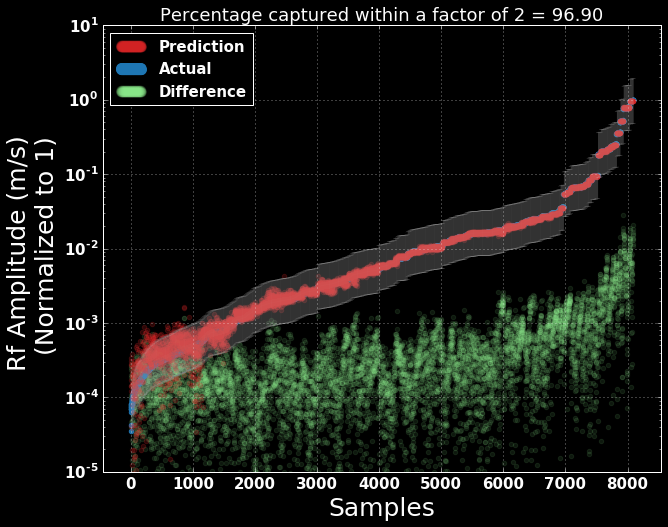

In [10]:
# Rescale back to original 


## Percentage within the specified factor
Fac = 2
IDX = y_pred/y_test >= 1
K = y_pred[IDX]
Q = y_test[IDX]
L = y_pred[~IDX]
M = y_test[~IDX]
Upper_indices = [i for i, x in enumerate(K <= Fac*Q) if x == True]
Lower_indices = [i for i, x in enumerate(L >= M/Fac) if x == True]
Percent_within_Fac = (len(Upper_indices) + len(Lower_indices))/len(y_pred)*100
print("Percentage captured within a factor of {} = {:.2f}".format(Fac,Percent_within_Fac))



# sort results in Ascending order
y_test_sort = np.sort(y_test,axis=0)
y_pred_sort = y_pred[np.argsort(y_test,axis=0)]

Diff = abs(y_pred_sort - np.expand_dims(y_test_sort,axis=1))

# Errorbar values
yerr_lower = y_test_sort - y_test_sort/Fac
yerr_upper = Fac*y_test_sort - y_test_sort


idx = np.arange(0,len(y_test_sort))


# Plot Results
font = {'weight' : 'bold',
        'size'   : 15}

plt.rc('font', **font)
plt.rc('legend',**{'fontsize':15})


plt.figure(figsize=(10,8))

plt.style.use('dark_background')
#plt.style.use('ggplot')

diff_plt = plt.scatter(idx,Diff,color='lightgreen',alpha=0.1)


errorbar_plt = plt.errorbar(idx,y_test_sort,yerr=[yerr_lower,yerr_upper], alpha=0.02 ,color='lightgrey')
actual_plt = plt.scatter(idx,y_test_sort,color='#1f77b4',alpha=0.9)


idx2 = np.arange(0,len(y_pred_sort))
pred_plt = plt.scatter(idx2,y_pred_sort,color='#d62728',alpha=0.2)      



plt.yscale('log')
plt.grid()
#plt.ylim([1e-7, 1e-3])
plt.ylabel('Rf Amplitude (m/s) \n (Normalized to 1)',fontsize=25)
plt.xlabel('Samples',fontsize=25)
plt.title("Percentage captured within a factor of {} = {:.2f}".format(Fac,Percent_within_Fac))
legend_plt = plt.legend([pred_plt,actual_plt, diff_plt],['Prediction', 'Actual', 'Difference'],loc=2,markerscale=2., scatterpoints=100)


plt.autoscale(enable=True, axis='x', tight=True)
plt.grid(linestyle=':')



save_results = 1

if save_results:
    
    # Create directory
    result_folder_name = './Saved_Models/Model_{}'.format(run_number)
    os.makedirs(result_folder_name)
    # Save Figure 
    plt.savefig('./Saved_Models/Model_{}/DNN_Rfamp_results.png'.format(run_number),bbox_inches='tight')
    
    # Save Model
    # serialize model to JSON
    model_json = model.to_json()
    with open("./Saved_Models/Model_{}/model.json".format(run_number), "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("./Saved_Models/Model_{}/model.h5".format(run_number))
    print("Saved model to disk")



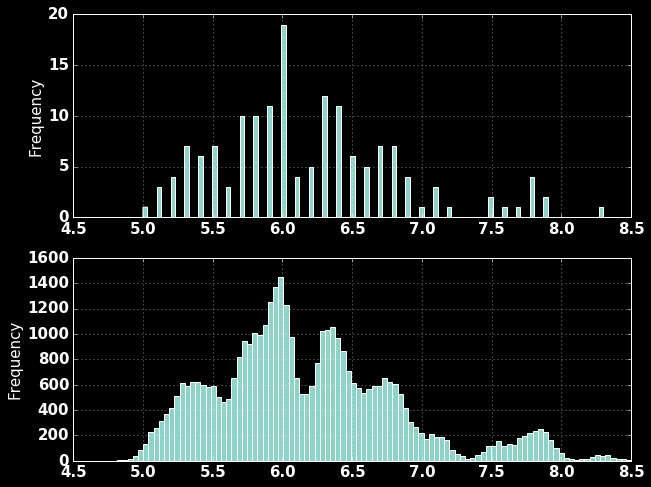

In [11]:
# Magnitude Distribution [Acutal vs Boosted Data]
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(10,8))
data_initial[1].plot.hist(ax=axes[0],bins=100,xlim=([4.5,8.5]),grid='on');  
data_temp[1].plot.hist(ax=axes[1],bins=100, xlim=([4.5,8.5]),grid='on');




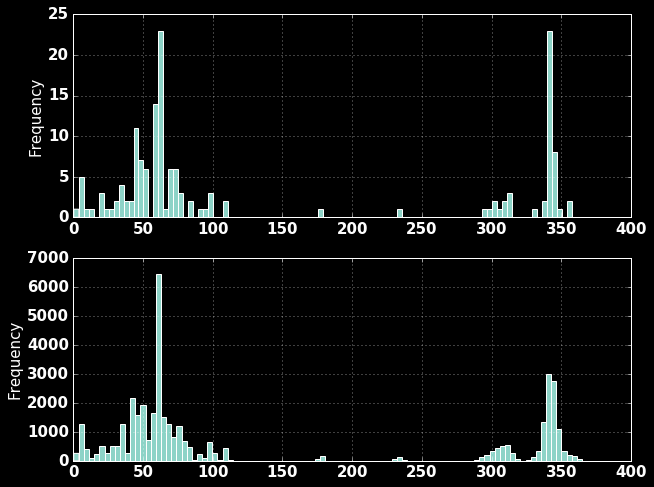

In [12]:
# Distribution
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(10,8))
data_initial[14].plot.hist(ax=axes[0],bins=100,grid='on');  
data_temp[14].plot.hist(ax=axes[1],bins=100,grid='on');


In [ ]:
'''


data_origScale= min_max_scaler.inverse_transform(data)
data_origScale = pd.DataFrame(data_origScale)

# Rescale back to original 
y_test_rescaled = y_test*(max(data_origScale[25]) - min(data_origScale[25])) + min(data_origScale[25])
y_pred_rescaled = y_pred*(max(data_origScale[25]) - min(data_origScale[25])) + min(data_origScale[25])

## Percentage within the specified factor
Fac = 2
IDX = y_pred_rescaled/y_test_rescaled >= 1
K = y_pred[IDX]
Q = y_test[IDX]
L = y_pred[~IDX]
M = y_test[~IDX]
Upper_indices = [i for i, x in enumerate(K <= Fac*Q) if x == True]
Lower_indices = [i for i, x in enumerate(L >= M/Fac) if x == True]
Percent_within_Fac = (len(Upper_indices) + len(Lower_indices))/len(y_pred)*100
print("Percentage captured within a factor of {} = {:.2f}".format(Fac,Percent_within_Fac))

# sort results in Ascending order
y_test_sort = np.sort(y_test_us,axis=0)
y_pred_sort = y_pred_rescaled[np.argsort(y_test_us,axis=0)]



# Errorbar values
yerr_lower = y_test_sort - y_test_sort/Fac
yerr_upper = Fac*y_test_sort - y_test_sort


idx = np.arange(0,len(y_test_sort))


font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}


plt.rc('font', **font)
plt.rc('legend',**{'fontsize':15})


plt.figure(figsize=(10,8))
actual_plt = plt.scatter(idx,y_test_sort,color='red',alpha=0.7,s=5)
errorbar_plt = plt.errorbar(idx,y_test_sort,yerr=[yerr_lower,yerr_upper], alpha=0.005 )

idx2 = np.arange(0,len(y_pred_sort))
pred_plt = plt.scatter(idx2,y_pred_sort,color='green',alpha=0.7)      

plt.yscale('log')
plt.grid()
plt.ylim([1e-7, 1e-3])
plt.ylabel('Rf Amplitude',fontsize=25)
plt.xlabel('Samples',fontsize=25)
plt.title("Percentage captured within a factor of {} = {:.2f}".format(Fac,Percent_within_Fac))
plt.legend([pred_plt,actual_plt],['Prediction', 'Actual'],loc=2)
plt.autoscale(enable=True, axis='x', tight=True)

#plt.savefig('DNN_Rfamp.png',bbox_inches='tight')

'''